In [1]:
import numpy as np
import pandas as pd
import joblib
import json
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import optuna
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def load_data_with_scaling_encoding_dtypes():
    # Define dtypes for train_transaction
    dtypes_train_transaction = {
        'TransactionID': 'int32',
        'isFraud': 'int8',
        'TransactionDT': 'int32',
        'TransactionAmt': 'float32',
        'ProductCD': 'object',
        'card1': 'int16',
        'card2': 'float32',
        'card3': 'float32',
        'card4': 'object',
        'card5': 'float32',
        'card6': 'object',
        'addr1': 'float32',
        'addr2': 'float32',
        'dist1': 'float32',
        'dist2': 'float32',
        'P_emaildomain': 'object',
        'R_emaildomain': 'object',
        # Add all C, D, M, V features
        **{f'C{i}': 'float32' for i in range(1, 15)},
        **{f'D{i}': 'float32' for i in range(1, 16)},
        **{f'M{i}': 'object' for i in range(1, 10)},
        **{f'V{i}': 'float32' for i in range(1, 340)}
    }

    # Define dtypes for train_identity
    dtypes_train_identity = {
        **{f'id_{i:02}': 'float32' for i in range(1, 12)},
        'id_12': 'object',
        'id_13': 'float32',
        'id_14': 'float32',
        'id_15': 'object',
        'id_16': 'object',
        **{f'id_{i:02}': 'float32' for i in range(17, 40)},
        **{f'id_{i:02}': 'object' for i in range(23, 39)},
        'DeviceType': 'object',
        'DeviceInfo': 'object'
    }

    # Define dtypes for test datasets
    dtypes_test_transaction = dtypes_train_transaction.copy()
    del dtypes_test_transaction['isFraud']  # Test data does not contain 'isFraud'

    dtypes_test_identity = dtypes_train_identity.copy()

    # Read in datasets with dtypes
    train_transaction = pd.read_csv(
        '/kaggle/input/ieee-fraud-detection/train_transaction.csv', 
        dtype=dtypes_train_transaction
    )
    train_identity = pd.read_csv(
        '/kaggle/input/ieee-fraud-detection/train_identity.csv', 
        dtype=dtypes_train_identity
    )
    test_transaction = pd.read_csv(
        '/kaggle/input/ieee-fraud-detection/test_transaction.csv', 
        dtype=dtypes_test_transaction
    )
    test_identity = pd.read_csv(
        '/kaggle/input/ieee-fraud-detection/test_identity.csv', 
        dtype=dtypes_test_identity
    )

    # Standardize column names
    test_identity.columns = test_identity.columns.str.replace('-', '_')
    test_transaction.columns = test_transaction.columns.str.replace('-', '_')

    # Merge datasets
    train = train_transaction.merge(train_identity, how='left', on='TransactionID')
    test = test_transaction.merge(test_identity, how='left', on='TransactionID')

    # Free up memory
    del train_transaction, train_identity, test_transaction, test_identity
    gc.collect()

    # Handle missing values
    train.fillna(-999, inplace=True)
    test.fillna(-999, inplace=True)

    # Define categorical features
    categorical_features = [
        'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
        'id_33', 'id_34', 'DeviceType', 'DeviceInfo'
    ]
    categorical_features += [f'id_{i}' for i in range(12, 39)]

    # Encode categorical features
    for col in categorical_features:
        if col in train.columns:
            train[col] = train[col].astype(str)
            test[col] = test[col].astype(str)

            le = LabelEncoder()
            combined_data = pd.concat([train[col], test[col]], axis=0)
            le.fit(combined_data)
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

    return train, test

In [3]:
# Load the train and test datasets using the provided function
train, test = load_data_with_scaling_encoding_dtypes()

# Prepare features and target as done previously
X = train.drop(columns=['isFraud', 'TransactionID'])
y = train['isFraud']
X_test = test.drop(columns=['TransactionID'], errors='ignore')

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
def load_model_and_params(model_name, model_path, params_path):
    model = joblib.load(model_path)
    with open(params_path, 'r') as f:
        params = json.load(f)
    return model, params

In [5]:
optimized_lgb_model, lgb_best_params = load_model_and_params(
    'lgb', 
    '/kaggle/input/lgbm-opt/optimized_lgb_model.pkl', 
    '/kaggle/input/lgbm-opt/lgb_best_params.json'
)

In [6]:
optimized_xgb_model, xgb_best_params = load_model_and_params(
    'xgb', 
    '/kaggle/input/xgboost-opt/optimized_xgb_model.pkl', 
    '/kaggle/input/xgboost-opt/xgb_best_params.json'
)

In [7]:
optimized_cat_model, cat_best_params = load_model_and_params(
    'cat', 
    '/kaggle/input/catboost-opt/optimized_cat_model.pkl', 
    '/kaggle/input/catboost-opt/cat_best_params.json'
)

In [8]:
lgb_val_pred = optimized_lgb_model.predict(X_val, num_iteration=optimized_lgb_model.best_iteration)
xgb_val_pred = optimized_xgb_model.predict_proba(X_val)[:, 1]
cat_val_pred = optimized_cat_model.predict_proba(X_val)[:, 1]

lgb_test_pred = optimized_lgb_model.predict(X_test, num_iteration=optimized_lgb_model.best_iteration)
xgb_test_pred = optimized_xgb_model.predict_proba(X_test)[:, 1]
cat_test_pred = optimized_cat_model.predict_proba(X_test)[:, 1]

In [9]:
def get_report(name,preds,thresh=0.5):
    print(name,"-------","Confusion Matrix",sep = "\n\n")
    preds_bin = (preds>thresh)
    print(confusion_matrix(y_val,preds_bin))
    print("-------","Classification Report",sep = "\n\n")
    print(classification_report(y_val,preds_bin))
    print("-------","Auc",sep = "\n\n")
    print(roc_auc_score(y_val,preds))
    print("-------","ROC",sep ="\n\n")
    fpr, tpr, _ = roc_curve(y_val, preds)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Optimized {name}')
    plt.legend(loc="lower right")
    plt.show()


LGBm

-------

Confusion Matrix
[[113850    125]
 [  1446   2687]]
-------

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.96      0.65      0.77      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.82      0.88    118108
weighted avg       0.99      0.99      0.99    118108

-------

Auc
0.9739549812982428
-------

ROC


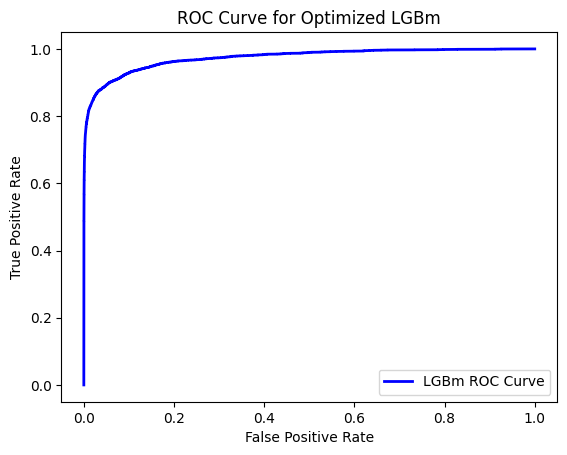

In [10]:
get_report("LGBm",lgb_val_pred)

XGBoost

-------

Confusion Matrix
[[113836    139]
 [  2174   1959]]
-------

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.93      0.47      0.63      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.74      0.81    118108
weighted avg       0.98      0.98      0.98    118108

-------

Auc
0.941839073444513
-------

ROC


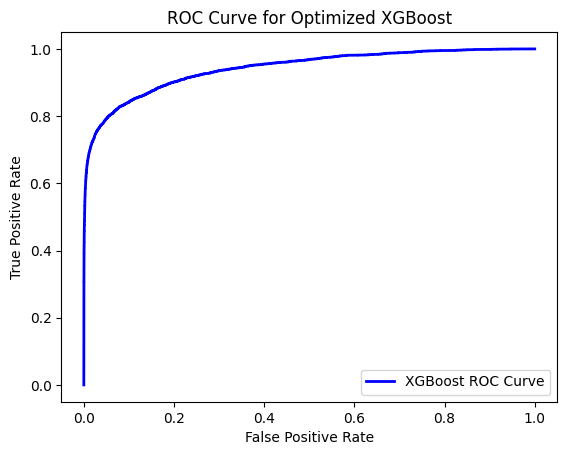

In [11]:
get_report("XGBoost",xgb_val_pred)

Cat Boost

-------

Confusion Matrix
[[113861    114]
 [  2111   2022]]
-------

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.95      0.49      0.65      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.74      0.82    118108
weighted avg       0.98      0.98      0.98    118108

-------

Auc
0.9365403619835683
-------

ROC


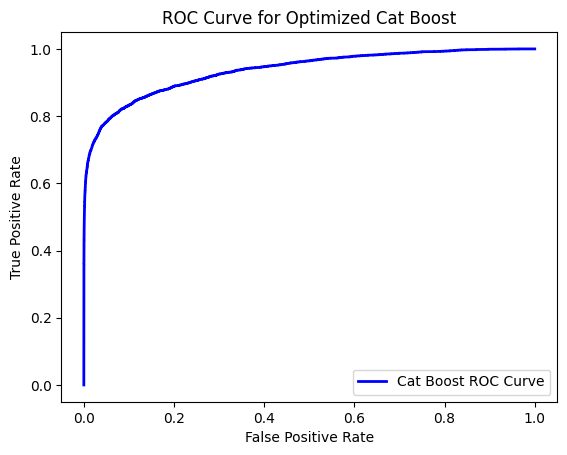

In [12]:
get_report("Cat Boost",cat_val_pred)

In [13]:
def objective(trial):
    # Suggest weights for each model
    weight_lgb = trial.suggest_float('weight_lgb', 0, 1)
    weight_xgb = trial.suggest_float('weight_xgb', 0, 1)
    weight_cat = trial.suggest_float('weight_cat', 0, 1)
    
    # Normalize weights
    total_weight = weight_lgb + weight_xgb + weight_cat
    weight_lgb /= total_weight
    weight_xgb /= total_weight
    weight_cat /= total_weight
    
    # Compute weighted ensemble predictions
    ensemble_val_pred = (
        weight_lgb * lgb_val_pred +
        weight_xgb * xgb_val_pred +
        weight_cat * cat_val_pred
    )
    
    # Calculate AUC
    auc = roc_auc_score(y_val, ensemble_val_pred)
    return auc

In [14]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=8888)

[I 2025-03-19 10:32:12,268] A new study created in memory with name: no-name-e3ee54a9-f9fd-413f-aa38-38b2b4dfc269
[I 2025-03-19 10:32:12,310] Trial 0 finished with value: 0.9586363652043984 and parameters: {'weight_lgb': 0.3745401188473625, 'weight_xgb': 0.9507143064099162, 'weight_cat': 0.7319939418114051}. Best is trial 0 with value: 0.9586363652043984.
[I 2025-03-19 10:32:12,351] Trial 1 finished with value: 0.9700293726678528 and parameters: {'weight_lgb': 0.5986584841970366, 'weight_xgb': 0.15601864044243652, 'weight_cat': 0.15599452033620265}. Best is trial 1 with value: 0.9700293726678528.
[I 2025-03-19 10:32:12,392] Trial 2 finished with value: 0.9491058348516774 and parameters: {'weight_lgb': 0.05808361216819946, 'weight_xgb': 0.8661761457749352, 'weight_cat': 0.6011150117432088}. Best is trial 1 with value: 0.9700293726678528.
[I 2025-03-19 10:32:12,433] Trial 3 finished with value: 0.9653715028175629 and parameters: {'weight_lgb': 0.7080725777960455, 'weight_xgb': 0.02058449

In [15]:
best_weights = study.best_params
total_weight = sum(best_weights.values())
best_weights = {k: v / total_weight for k, v in best_weights.items()}
print(f"Optimal weights found: {best_weights}")

Optimal weights found: {'weight_lgb': 0.9999496856615793, 'weight_xgb': 1.1958333377866684e-05, 'weight_cat': 3.8356005042864784e-05}


In [16]:
ensemble_val_pred = (
    best_weights['weight_lgb'] * lgb_val_pred +
    best_weights['weight_xgb'] * xgb_val_pred +
    best_weights['weight_cat'] * cat_val_pred
)

Ensemble

-------

Confusion Matrix
[[113850    125]
 [  1446   2687]]
-------

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.96      0.65      0.77      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.82      0.88    118108
weighted avg       0.99      0.99      0.99    118108

-------

Auc
0.9739546140403845
-------

ROC


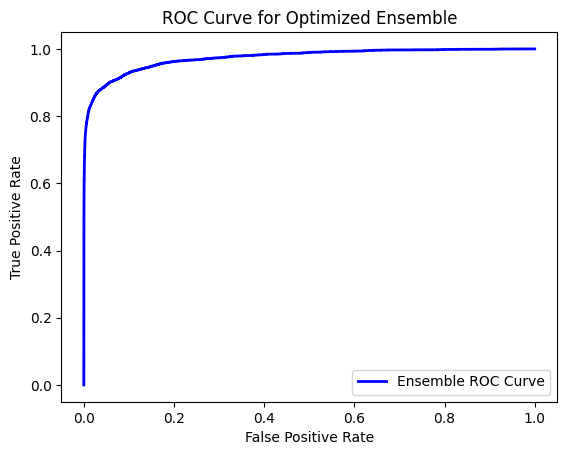

In [17]:
get_report("Ensemble",ensemble_val_pred)

In [18]:
ensemble_test_pred = (
    best_weights['weight_lgb'] * lgb_test_pred +
    best_weights['weight_xgb'] * xgb_test_pred +
    best_weights['weight_cat'] * cat_test_pred
)

In [19]:
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': ensemble_test_pred
})

In [20]:
submission.to_csv('submission.csv', index=False)